### **Leakage detection**
--------------

##### **Libraries**
--------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scared
import estraces

from IPython.display import display
from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Useful functions and parameters
plt.rcParams["figure.figsize"] = (20,2)

vhex = np.vectorize(hex)
vhex2 = np.frompyfunc(format, 2, 1) 

##### **Loading the profiling data sets**
--------

In [3]:
ths_building = scared.traces.read_ths_from_ets_file('./dataset/profiling_hw_w0_v4.zip.ets')
ths_building

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ./dataset/profiling_hw_w0_v4.zip.ets with 749017 traces.
msg..............: uint8
w0...............: uint8
w0_hw............: uint8

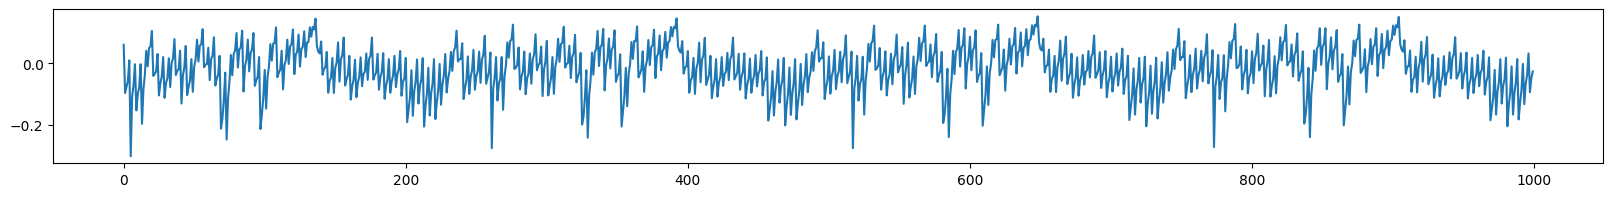

In [4]:
plt.plot(ths_building.samples[0])
plt.show()

#### **Reverse 4 bytes of `w0`**
----
We use the ANOVA distinguisher to perform a leakage detection of the 4 `w0` bytes

In [5]:
def identity_w0(msg, w0):
    return w0

S = scared.reverse_selection_function(function=identity_w0)

In [6]:
# The HammingWeight model will be applied to each of the 4 bytes of `w0`
ReverseANOVA = scared.ANOVAReverse(selection_function=S,
                                 model=scared.HammingWeight(),
                                 partitions = np.arange(9))

In [7]:
# We keep the first 1000 samples of each trace
container = scared.Container(ths_building, frame=range(0,1000))

In [8]:
ReverseANOVA.run(container)

##### ANOVA reverse results
-------------


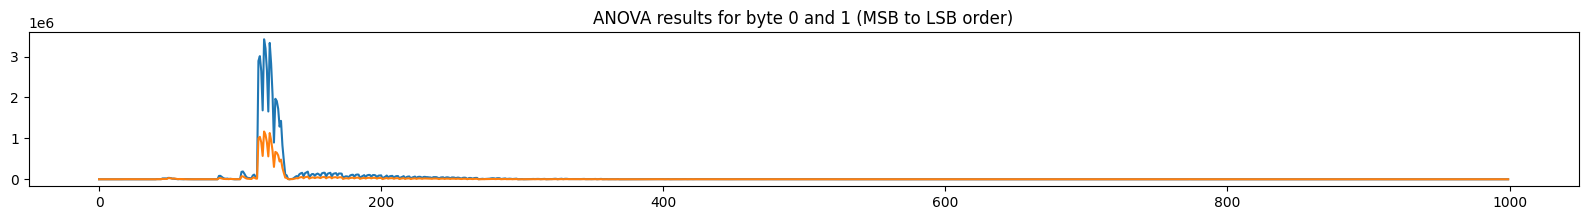

In [9]:
for i in range(0, 2):
    plt.plot(ReverseANOVA.results[i])
plt.title(f"ANOVA results for byte 0 and 1 (MSB to LSB order)")
plt.show()   

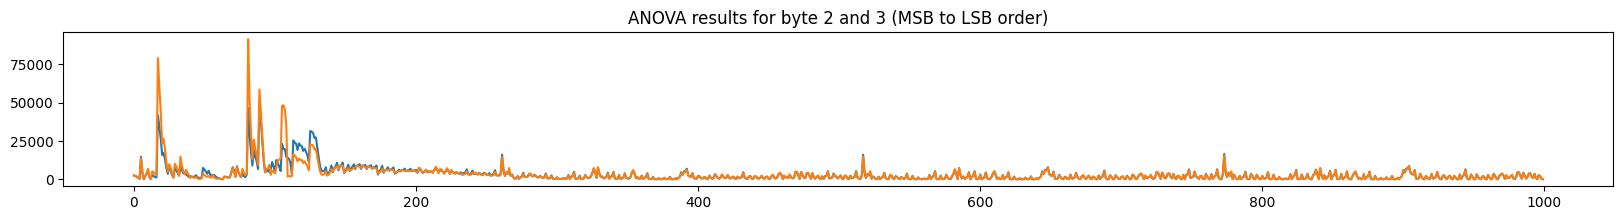

In [11]:
for i in range(2, 4):
    plt.plot(ReverseANOVA.results[i])
plt.title(f"ANOVA results for byte 2 and 3 (MSB to LSB order)")
plt.show()   

#### **POIs selection**
------

Now that we have the ANOVA results, we choose to select the maximum values as POIs 

For the rest of the notebooks `word` will refer to a byte

In [12]:
r = ReverseANOVA.results
pois = [np.argsort(r[word])[-5:] for word in range(4)]

@interact(word = (0, 3, 1))
def widget_pois(word=0):
    fg, ax = plt.subplots(figsize=(20, 4.5))
    ax.plot(ths_building.samples[:20, 0:200].T, alpha=0.19)
    ax2=ax.twinx()
    ax2.plot(r[word][0:200], color = "C0", alpha=1)
    
    plt.plot(pois[word], r[word, pois[word]][0:200], 'C1+')
    plt.title(f"POIs for word {word} (MSB to LSB order)")
    plt.show()

interactive(children=(IntSlider(value=0, description='word', max=3), Output()), _dom_classes=('widget-interact…

In [13]:
pois

[array([113, 114, 118, 121, 117], dtype=int64),
 array([113, 114, 118, 121, 117], dtype=int64),
 array([18, 90, 17, 81, 89], dtype=int64),
 array([82, 89, 18, 17, 81], dtype=int64)]

In [14]:
np.savez(f'./dataset/pois_profiling_hw_w0_v4.npz', pois=pois)